<a href="https://colab.research.google.com/github/mwl10/hetvae/blob/errors/src/catalina_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import shutil#
os.chdir('/content')
! git clone --branch errors https://github.com/mwl10/hetvae
os.chdir('/content/hetvae')
! pip install -r requirements.txt
os.chdir('/content/hetvae/src')
import numpy as np
import torch
import torch.optim as optim
import models
from argparse import Namespace
import torch.optim as optim
import utils
import my_utils
import pandas as pd
import importlib
import vae_models
from glob import glob
import matplotlib.pyplot as plt
import sys
from dataset import DataSet
%matplotlib inline

Cloning into 'hetvae'...
remote: Enumerating objects: 3821, done.
remote: Counting objects: 100% (857/857), done.
remote: Compressing objects: 100% (819/819), done.
remote: Total 3821 (delta 99), reused 82 (delta 38), pack-reused 2964
Receiving objects: 100% (3821/3821), 30.37 MiB | 22.25 MiB/s, done.
Resolving deltas: 100% (1044/1044), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 210 kB 13.3 MB/s 
     |████████████████████████████████| 81 kB 10.6 MB/s 
     |████████████████████████████████| 149 kB 60.6 MB/s 
     |████████████████████████████████| 78 kB 8.9 MB/s 
     |████████████████████████████████| 15.7 MB 69.7 MB/s 
     |████████████████████████████████| 308 kB 54.8 MB/s 
     |████████████████████████████████| 112 kB 74.6 MB/s 
     |████████████████████████████████| 2.1 MB 41.2 MB/s 
     |████████████████████████████████| 596 kB 78.8 MB/s 
     |██████████████████████████████

['/content/hetvae/data/CAT/CSS/CSS170928:014736+155300_19.65.dat', '/content/hetvae/data/CAT/CSS/CSS170201:032419+151858_18.88.dat', '/content/hetvae/data/CAT/CSS/CSS170201:095935+281239_18.34.dat', '/content/hetvae/data/CAT/CSS/CSS170201:114232+200717_20.13.dat', '/content/hetvae/data/CAT/CSS/CSS171001:030632+143102_18.92.dat', '/content/hetvae/data/CAT/CSS/CSS170304:122225+271222_19.64.dat', '/content/hetvae/data/CAT/CSS/CSS170925:034553-154102_19.07.dat', '/content/hetvae/data/CAT/CSS/CSS170928:000609+183719_19.6.dat', '/content/hetvae/data/CAT/CSS/CSS170419:125107+030511_18.4.dat', '/content/hetvae/data/CAT/CSS/CSS170925:235758-120558_18.32.dat', '/content/hetvae/data/CAT/CSS/CSS170201:084317+101227_19.43.dat', '/content/hetvae/data/CAT/CSS/CSS170130:102912+510535_20.17.dat', '/content/hetvae/data/CAT/CSS/CSS170130:093832+503858_19.45.dat', '/content/hetvae/data/CAT/CSS/CSS170504:144757+132212_18.9.dat', '/content/hetvae/data/CAT/CSS/CSS170506:144139+531059_17.8.dat', '/content/het

/content/hetvae/src/dataset.py:325: RuntimeWarning: divide by zero encountered in true_divide
  self.dataset[:,:,2] = 1. / self.dataset[:,:,2]


created subsampled_mask & recon_mask instance attributes
['/content/hetvae/data/CAT/CSS/CSS170928:014736+155300_19.65.dat', '/content/hetvae/data/CAT/CSS/CSS170201:032419+151858_18.88.dat', '/content/hetvae/data/CAT/CSS/CSS170201:095935+281239_18.34.dat', '/content/hetvae/data/CAT/CSS/CSS170201:114232+200717_20.13.dat', '/content/hetvae/data/CAT/CSS/CSS171001:030632+143102_18.92.dat', '/content/hetvae/data/CAT/CSS/CSS170304:122225+271222_19.64.dat', '/content/hetvae/data/CAT/CSS/CSS170925:034553-154102_19.07.dat', '/content/hetvae/data/CAT/CSS/CSS170928:000609+183719_19.6.dat', '/content/hetvae/data/CAT/CSS/CSS170419:125107+030511_18.4.dat', '/content/hetvae/data/CAT/CSS/CSS170925:235758-120558_18.32.dat', '/content/hetvae/data/CAT/CSS/CSS170201:084317+101227_19.43.dat', '/content/hetvae/data/CAT/CSS/CSS170130:102912+510535_20.17.dat', '/content/hetvae/data/CAT/CSS/CSS170130:093832+503858_19.45.dat', '/content/hetvae/data/CAT/CSS/CSS170504:144757+132212_18.9.dat', '/content/hetvae/data

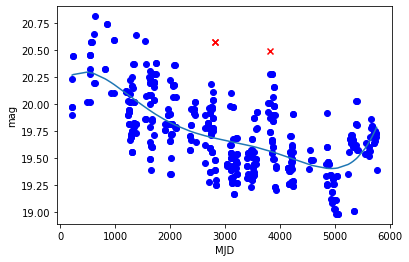

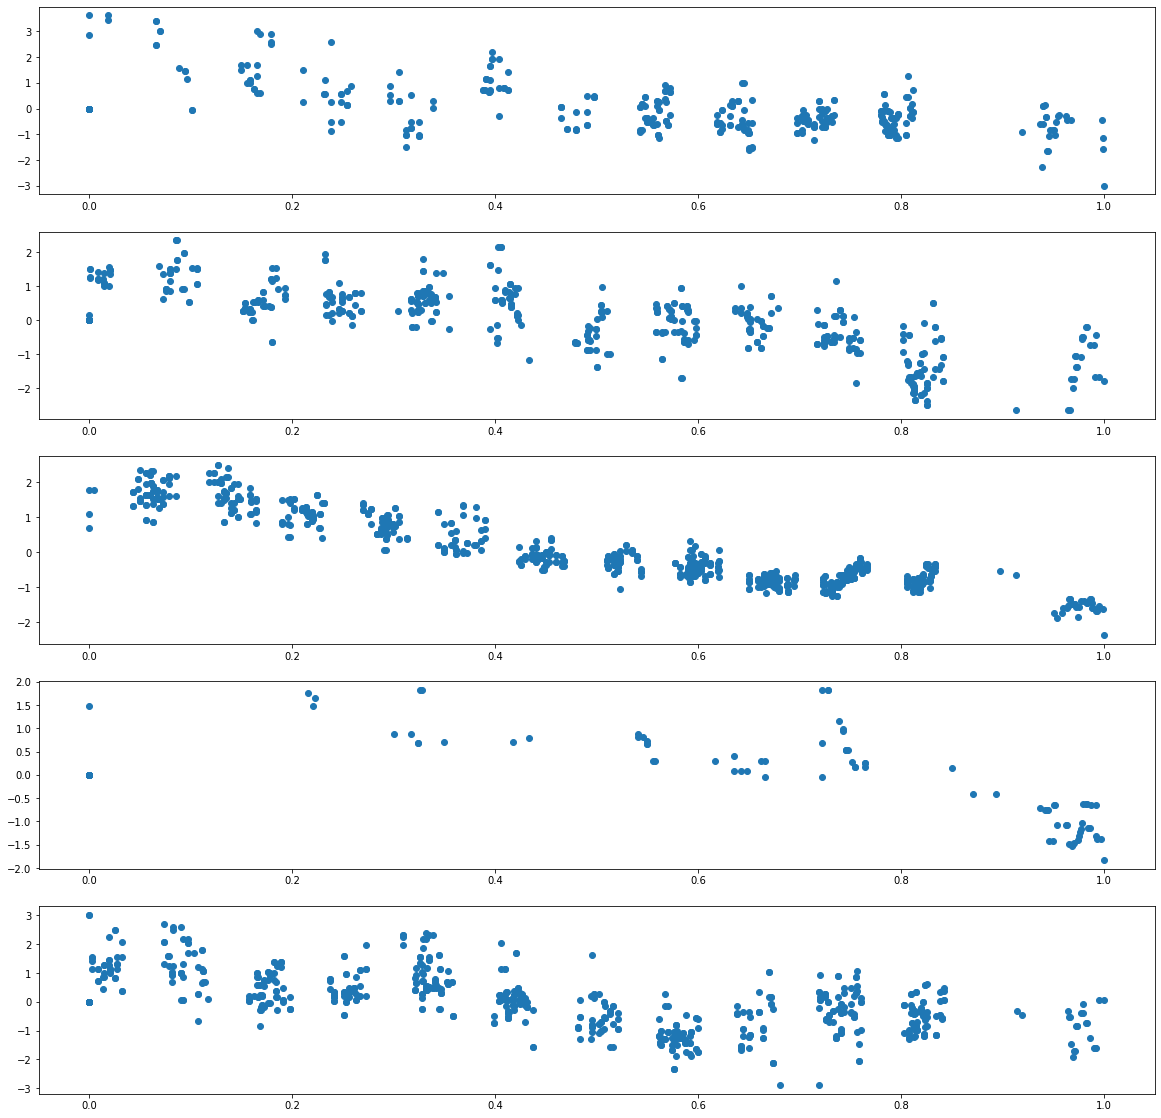

In [2]:
#--------------------------------------------------------------------------------------------------------
# PREPROCESSING, from Catalina data
#--------------------------------------------------------------------------------------------------------
lc_files = glob('/content/hetvae/data/CAT/*/*')[:50]
print(lc_files)
Catalina = DataSet() \
            .add_files(lc_files) \
            .files_to_numpy(maximum=1000) \
            .handle_dups() \
            .prune_graham(plot=True, index=5) \
            .normalize(normalize_x='individual', normalize_y='individual', x_by_range=True) \
            .reorder() \
            .set_union_x() \
            .zero_fill() \
            .error_to_sample_weight() \
            .make_masks(frac=0.5)


print(
    Catalina.files, '\n',
    Catalina.union_x.shape,
    Catalina.dataset.shape,
    Catalina.subsampled_mask.shape,
    Catalina.recon_mask.shape
  )
fig,ax = plt.subplots(5,1, figsize=(20,20))
for i in range(5):
    ax[i].scatter(Catalina.dataset[i,:,0], Catalina.dataset[i,:,1])

In [9]:
# num heads?
args = Namespace(batch_size=8, bound_variance=False, const_var=False,dropout=0.3, 
                 elbo_weight=1, embed_time=32, enc_num_heads=4, intensity=True, k_iwae=1, kl_annealing=False, 
                 kl_zero=False, latent_dim=64, lr=0.001, mixing='concat_and_mix', mse_weight=1., net='hetvae', 
                 niters=1000, norm=True, normalize_input='znorm', num_ref_points=64, rec_hidden=64, recon_loss=False, 
                 sample_tp=0.33, save=True, seed=0, shuffle=True, std=0.9, var_per_dim=False, width=64)

DIM = 1
# definitly want a decaying error rate...
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[], gamma=0.1)
seed = args.seed
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
LightCurves = np.concatenate((Catalina.dataset, Catalina.subsampled_mask[:,:,np.newaxis], Catalina.recon_mask[:,:,np.newaxis]), axis=-1) # format the masks for the model 


In [11]:
training, valid = np.split(LightCurves, [int(np.floor(0.8*len(LightCurves)))])# shuffle?

train_loader = torch.utils.data.DataLoader(training, batch_size=args.batch_size)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=args.batch_size)

net = models.load_network(args, DIM, torch.Tensor(Catalina.union_x)) 
params = list(net.parameters())
# try different union x? 

RuntimeError: ignored

In [ ]:
reconstruction, qz_mean, qz_std = viz_per_example(AGN_1H2106.dataset[0], AGN_1H2106.target_x[0], net, device=device, k_iwae=50)

# visualisation for one light curve w/ increasing number of points
def viz_per_example(example, target_x, net, device="cuda", k_iwae=10, frac=0.5): 
    example = example[np.newaxis, :,:]
    target_x = target_x[np.newaxis, :, np.newaxis]
    np.random.seed(0)
    with torch.no_grad(): 
        if torch.is_tensor(example):
            example = example.cpu().numpy()
        # make new masks relative to fraction of points we got to predict w/ 
        smask, rmask = my_utils.make_masks(example, frac=frac)
        example = np.concatenate((example, smask[:,:,np.newaxis], rmask[:,:,np.newaxis], target_x), axis=-1) # format the masks 
        
        example = torch.tensor(example)
        example = example.to(device)
        
        subsampled_mask = example[:,:,3:4]
        context_y = torch.cat((example[:,:, 1:2] * subsampled_mask, subsampled_mask), -1)
        px, qz = net.get_reconstruction(example[:,:, 0], context_y, example[:,:,5], num_samples=k_iwae)

        qz_mean = (qz.mean.cpu().numpy())
        qz_std = (torch.exp(0.5 * qz.logvar).cpu().numpy())
        px_mean = px.mean.cpu().numpy()
        px_std = torch.exp(0.5 * px.logvar).cpu().numpy()
        example = example.cpu().numpy()

        px_mean = np.mean(px_mean, axis=0)[0,:200,0]
        px_std = np.mean(px_std, axis=0)[0,:200,0]
        target_x = target_x[0,:200,0]
        w=2.0
        plt.figure(figsize=(30, 10))
        #plt.fill_between(target_x, px_mean - 2*px_std, px_mean+2*px_std, color='gray')

        plt.plot(target_x, px_mean, c='b', lw=w, label='Reconstructions', zorder=20)
        plt.scatter(example[0,:,0], example[0,:,1])
        plt.errorbar(target_x, px_mean ,yerr=px_std,  ecolor='#65c9f7', c='b', lw=w, label='Reconstructions')

        plt.show()
        reconstruction = np.concatenate((target_x[:,np.newaxis], px_mean[:,np.newaxis], px_std[:,np.newaxis]), axis=1)
        print(f'qz shape: {qz_mean.shape}')
        print(f'reconstructed example: {reconstruction.shape}')
        return reconstruction, qz_mean,qz_std

In [ ]:
x_mean, x_std = AGN_1H2106.x_mean_std[0]
y_mean, y_std = AGN_1H2106.y_mean_std[0]


x = (reconstruction[:,0] * x_std) + x_mean
y = (reconstruction[:,1] * y_std) + y_mean
yerr = reconstruction[:,2] * y_std
plt.errorbar(x,y,yerr=yerr)

denorm_AGN = AGN_1H2106.error_to_sample_weight().denormalize()
x = denorm_AGN[0,:,0]
y = denorm_AGN[0,:,1]

yerr = denorm_AGN[0,:,2]



plt.errorbar(x,y,yerr=yerr, fmt='o')